<a href="https://colab.research.google.com/github/stefanogiagu/corsoinfn/blob/main/notebooks2/Hands_on_1_CNN_su_Acceleratori_FPGA_6_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training, pruning e quantizzazione di una CNN allenata per una task di regressione**

Use case: trigger di alto livello di vertici secondari nello spettrometro muonico dell'esperimento ATLAS

*   training di un modello CNN con archiettura tipo VGG
*   pruning del modello con tensorflow
*   compressione del modello potato tramite quantizzazione a 8bit con tensorflow

Referenze: <p>
[Tensorflow Model Optimization](https://www.tensorflow.org/model_optimization/guide) <p>
[VitisAI](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html) <p>

Dataset: scaricabile da web usando il comando *wget* (3GB, richiede ~3' da google colab per essere scaricato)




In [1]:
!wget http://giagu.web.cern.ch/giagu/CERN/MS_vertex_10_v3.npz

--2022-12-05 16:27:43--  http://giagu.web.cern.ch/giagu/CERN/MS_vertex_10_v3.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3197282064 (3.0G)
Saving to: ‘MS_vertex_10_v3.npz’

MS_vertex_10_v3.npz 100%[===================>]   2.98G  44.3MB/s    in 1m 51s  

2022-12-05 16:29:35 (27.5 MB/s) - ‘MS_vertex_10_v3.npz’ saved [3197282064/3197282064]



In [1]:
# Lettura del dataset, in formato numpy compresso (.npz)

import tempfile
import os
import numpy as np

# 10000 immagini (eventi) 20x333 (layers MDT ATLAS, coordinata z) degli hit nello spettrometro muonico rilasciati dal decadimento di nuove particelle che decadono in multi muoni
# 'data_noise': array immagini (1000,20,333)
# 'labels': array (10000,3) in cui la prima grandezza rappresenta la distanza di decadimento della particelle che ha prodotto l'immagine

input_file = np.load('MS_vertex_10_v3.npz')
labels = input_file['labels']
data_noise = input_file['data_noise']

print("data_noise shape : ",data_noise.shape)
print("labels shape :     ",labels.shape)

data_noise shape :  (10000, 20, 333)
labels shape :      (10000, 3)


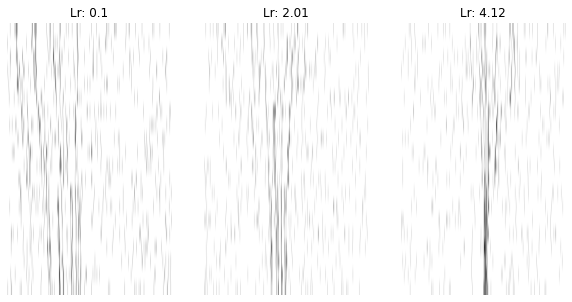

In [2]:
# esempio di immagini

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for i, idx in enumerate([29,22,30]):
  plt.subplot(1,3,i+1)
  plt.imshow(data_noise[idx], origin='lower', aspect='auto', cmap='binary')
  plt.axis('off')
  plt.xlabel('z')
  plt.ylabel('mdt layer')
  plt.title('Lr: '+str(round(labels[idx,0],2)))

In [3]:
# Preprocessamento dei dati:

# utilizziamo solo la prima variabile delle label (distanza di decadimento) per addestrare la CNN a predire tale variabile
decay_lenght = labels[:,0]

# dividiamo il dataset in training and test set utilizzando il metodo train_test_split di sklearn
from sklearn.model_selection import train_test_split
train_to_test_ratio = 0.8 # training set 80%, test set 20% 
X_train,X_test,Y_train,Y_test = train_test_split(data_noise, decay_lenght, train_size=train_to_test_ratio, shuffle=True, random_state=1234)

# normaizziamo in [0,1]
maxv = np.max(X_train)
X_train = X_train/maxv
X_test = X_test/maxv

# reshaping delle immagini di training da (10000,20,333) a (10000,20,333,1) come richiesto da layer convoluzionali in keras
X_train = X_train.reshape((X_train.shape[0], 20, 333,1))
X_test = X_test.reshape((X_test.shape[0], 20, 333,1))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# conversione dei valori degli array a float32 come richiesto da keras
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_test  = X_test.astype('float32')
Y_test  = Y_test.astype('float32')

(8000, 20, 333, 1)
(8000,)
(2000, 20, 333, 1)
(2000,)


In [4]:
# Modello Tenworflow/Keras

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

# Usiamo un'archiettura CNN tipo VGG, semplice da implementare e che funziona bene per identificare i tipici pattern di particelle in rivelatori 
# traccianti

# modello funzionale
inputs = keras.Input(shape=(20,333,1))

# primo blocco convoluzionale (tre convoluzioni 2D con 32 kernel 3x3 (che corrispondono ad un campo ricettivo 7x7) + attivazione relu per inserire 
# non linerità nel modello e un max pooling finale 

# NOTA: usiamo padding='same' nelle convoluzioni e utilizziamo un layer di max pooling per il downsampling dell'output 
x = keras.layers.Conv2D(64, kernel_size=(3,3), padding='same')(inputs)
x = keras.layers.Conv2D(64, kernel_size=(3,3), padding='same')(x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), padding='same')(x)
x = keras.layers.ReLU(name='ReLU')(x)
x = keras.layers.MaxPool2D((2,3))(x)

# secondo blocco convoluzionale: una convoluzione 2D con 128 kernel (3,3) + relu + max pooling
x = keras.layers.Conv2D(128, kernel_size=(3,3), padding='same')(x)
x = keras.layers.ReLU(name='ReLU1')(x)
x = keras.layers.MaxPool2D((2,3))(x)

# terzo blocco convoluzionale: una convoluzione 2D con 256 kernel (3,3) senza padding + relu + max pooling (solo lungo la seconda dimensione)
x = keras.layers.Conv2D(256, kernel_size=(3,3))(x)
x = keras.layers.ReLU(name='ReLU2')(x)
x = keras.layers.MaxPool2D((1,3))(x)

# quarto blocco convoluzionale: una convoluzione 2D con 256 kernel (3,3) senza padding + relu + max pooling (solo lungo la seconda dimensione)
x = keras.layers.Conv2D(256, kernel_size=(3,3))(x)
x = keras.layers.ReLU(name='ReLU3')(x)
x = keras.layers.MaxPool2D((1,3))(x)

# flatten layer per adattare l'uscita dell'ultima convoluzione al blocco fully connected usato per la task di regressione
x = keras.layers.Flatten()(x)

# fully connected block: layer densi + relu + dropout come regolarizzatore per ritardare l'overfitting
x = keras.layers.Dense(1024)(x)
x = keras.layers.ReLU(name='ReLU4')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024)(x)
x = keras.layers.ReLU(name='ReLU5')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1)(x)
outputs = keras.layers.ReLU(name='ReLU6')(x)

# modello finale
model = keras.Model(inputs=inputs, outputs=outputs)

# printout della struttura del modello
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 333, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 333, 64)       36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 333, 64)       36928     
                                                                 
 ReLU (ReLU)                 (None, 20, 333, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 111, 64)      0         
 )                                                               
                                                             

In [5]:
# Compilazione del modello

# Ottmizzatore: usiamo Adam con larning rate iniziale fisso
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss: usiamo mse (Mean Squared Error == norma L2)

model.compile(optimizer=OPTIMIZER,
              loss='mse',
              metrics=['mae']) #come metrica per monitorare l'addestramento usiamo mae (Mean Absolute Error) più intuitiva da analizzare

In [6]:
# schedule:

# usiamo una semplice learnign rate schedule per variare (diminuire) durante il training il larning-rate
# in modo che valori iniziali più grandi permettano una buona esplorazione del landscape della loss, e valori più 
# piccoli permettano una esplorazione dettagliata una volta individuata una regione di minimo  

# prime 5 epoche LR costante, poi decay esponenziale
def lr_decay(epoch):
  if epoch < 5:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (5 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)


# schedula per salvare il modello migliore durante il training. Viene monitorata la mae sul campione di 
# validazione ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'float_best.h5',
        monitor='val_mae',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')


In [7]:
# Addestramento del modello

epoche = 30
batch_size = 64

# usiamo 20% del trainign set come campione di validazione per decidere quando fermarsi tramite la schedula del model_checkpoint
history = model.fit(X_train, Y_train, epochs=epoche, batch_size=batch_size,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[lr_scheduler, model_checkpoint])

Epoch 1/30
100/100 [==============================] - 11s 75ms/step - loss: 2.5603 - mae: 1.1455 - val_loss: 0.4934 - val_mae: 0.5679 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 8s 81ms/step - loss: 0.4047 - mae: 0.5081 - val_loss: 0.2927 - val_mae: 0.4196 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 0.2832 - mae: 0.4251 - val_loss: 0.2413 - val_mae: 0.3772 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 7s 75ms/step - loss: 0.2139 - mae: 0.3643 - val_loss: 0.1811 - val_mae: 0.3284 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 7s 75ms/step - loss: 0.1787 - mae: 0.3348 - val_loss: 0.1635 - val_mae: 0.3217 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 7s 75ms/step - loss: 0.1445 - mae: 0.2999 - val_loss: 0.1336 - val_mae: 0.2832 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 7s 75ms/step - loss: 0.1072 - mae: 0.2578 - val_loss: 0.1144 - val_ma

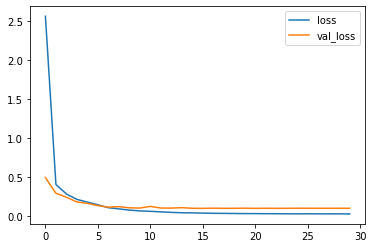

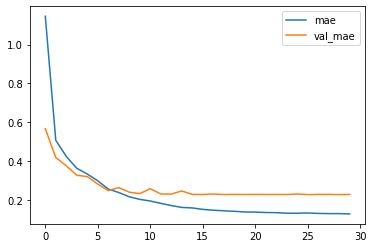

In [8]:
# plot loss e mae vs epoca di training

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.legend()
plt.show()

In [11]:
# Upload del best model 
from tensorflow import keras
model.load_weights('float_best.h5') 
model.save('float_model.h5')

In [12]:
# prestazioni sul test set
score = model.evaluate(X_test, Y_test, verbose=2)

63/63 - 1s - loss: 0.1055 - mae: 0.2378 - 1s/epoch - 22ms/step


63/63 [==============================] - 1s 13ms/step


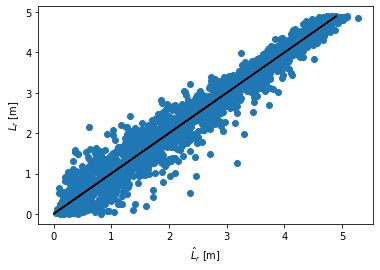

In [13]:
# scatter plot distanza di decadimento vera vs distanza di decadimento predetta

Y_predetta = model.predict(X_test.reshape((X_test.shape[0],20,333,1)))
plt.scatter(Y_predetta,Y_test)
plt.xlabel("$\hat{L}_r$ [m]")
plt.ylabel("$L_r$ [m]")
plt.plot(Y_test, Y_test ,'k-')

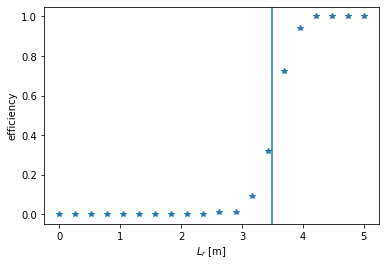

In [14]:
# Turnon curva di efficienza del trigger in funzione della distanza di decadimento

# modo facile per ottenerlo: creare due histogrammi uno con la distribuzione di Lr per gli eventi che passono il taglio 
# Lr_predetto > soglia e uno con la distribuzione di tutti gli eventi e poi fare il rapporto tra i due istogrammi

soglia = 3.5 #soglia nominale di trigger (e.g. il trigger seleziona partcielle con lunghezza di decadimento >= 3.5m)
numer,_ = np.histogram(Y_test[Y_predetta.reshape(Y_predetta.shape[0],)>soglia], bins=20, range=(0.,5.))
denum,_ = np.histogram(Y_test, bins=20, range=(0.,5.))

eff = numer/denum
lrvalues = np.linspace(0.,5.,20)

_ = plt.plot(lrvalues,eff, '*')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("$L_r$ [m]")
_ = plt.ylabel("efficiency")

In [15]:
# Installazione della libreria tensorflow model optimization
# fornisce diversi strumenti per l'ottimizzazione di modelli di NN per la riduzione della latenza, memory footprint, power consumption, network usage, 
# Moduli: weight pruning (per ridurre il numero di parametri della rete), quantization (a 8 bit,  per ridurre io memory foot print, e ottimizzare il trasferimento 
# dei dati verso/dalla memoria), weight clustering e ottmizzazione collaborativa (i parametri del modello vengono sostituiti da un umero più piccolo di valori unici) 

# 
!pip install -q tensorflow-model-optimization

In [16]:
# Pruning del Modello
import tensorflow_model_optimization as tfmot


# carichiamo il modello baseline non compresso 
baseline_model = keras.models.load_model('float_model.h5')


# Definiamo il modello di pruning da utilizzare: 
# si parte da una sparsity iniziale per layer del 50% (50% dei pesi azzerati) per arrivare ietrativamente ad
# una sparsity dell'80% (80% dei pesi azzerati) 
# il passaggio avviene con una schedula di decadimento polinomiale

# numero di step di ottmizzazione:

# NOTA BENE: nel pruning **NON** è una buona strategia ri-addestrare la rete, ma conviene solo fare un po' di fine tuning 
# addestrando per poche epoche (4-5 epoche)
epochs=5
batch_size=64

# numero di step
end_step = np.ceil(X_train.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
  'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


# applichiamo il pruning solo ai layer densi (quelli che hanno la maggior parte dei parametri)
# prune_low_magnitude elimina i pesi più piccoli in valore assoluto (è un wrapper che prende in input un layer, o una sequenza di layer, o un intero modello)
def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Usiamo `tf.keras.models.clone_model` per applicare `apply_pruning_to_dense`  ai layer del modello.
model_for_pruning = tf.keras.models.clone_model(
    baseline_model,
    clone_function=apply_pruning_to_dense,
)


# Compilazione del modello da potare (stessi parametri del modello baseline)
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

model_for_pruning.compile(optimizer=OPTIMIZER,
              loss='mse',
              metrics=['mae'])

model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 333, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 333, 64)       36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 333, 64)       36928     
                                                                 
 ReLU (ReLU)                 (None, 20, 333, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 111, 64)      0         
 )                                                               
                                                             

In [ ]:
#nota il modello ha molti più parametri (non addestrabili) che servono al keras_wrapper per gestire il processo di pruning del modello

In [17]:
# Pruning e fine tuning del modello

# è necessario inserire una schedula durante il training che chiami tfmot.sparsity.keras.UpdatePruningStep()
# (si occupa di effetturare tutte le operazioni di pruning)

# tfmot.sparsity.keras.PruningSummaries viene usaro per monitorare i progressi e per debugging 


callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir='test'),
  keras.callbacks.ModelCheckpoint(
        filepath = 'pruned_best.h5',
        monitor='val_mae',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')
]
  
history = model_for_pruning.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=0.2,
                  callbacks=callbacks)

Epoch 1/5
  6/100 [>.............................] - ETA: 7s - loss: 1.5390 - mae: 0.9717

100/100 [==============================] - 12s 79ms/step - loss: 0.2932 - mae: 0.3783 - val_loss: 1.3945 - val_mae: 0.9902
Epoch 2/5
100/100 [==============================] - 8s 76ms/step - loss: 0.1805 - mae: 0.3154 - val_loss: 0.1203 - val_mae: 0.2616
Epoch 3/5
100/100 [==============================] - 7s 75ms/step - loss: 0.0722 - mae: 0.2107 - val_loss: 0.2967 - val_mae: 0.4641
Epoch 4/5
100/100 [==============================] - 8s 76ms/step - loss: 0.0854 - mae: 0.2275 - val_loss: 0.1030 - val_mae: 0.2389
Epoch 5/5
100/100 [==============================] - 7s 75ms/step - loss: 0.0570 - mae: 0.1872 - val_loss: 0.1111 - val_mae: 0.2466


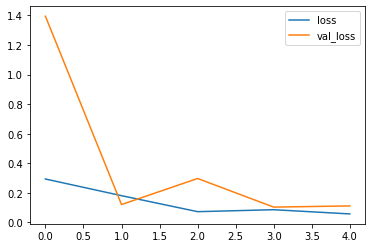

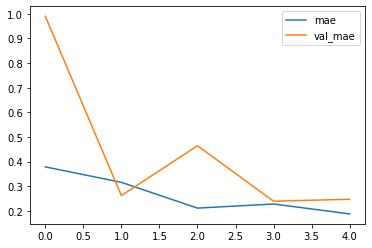

In [18]:
# loss, mae vs epoca 
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.legend()
plt.show()

In [21]:
# Per effetivamente comprimere il modello è necessario eliminare il keras wrapper usato durante il training 
# questo viene fatto usando il metodo tfmot.sparsity.keras.strip_pruning

# NOTA: se si vuole ridurre effettivamente il numero di pesi si deve comprimere il modello con tfLite (runtime essenziale di TF)

# load pesi best model
model_for_pruning.load_weights('pruned_best.h5') 

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'pruned_model.h5', include_optimizer=False)
model_for_export.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 333, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 333, 64)       36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 333, 64)       36928     
                                                                 
 ReLU (ReLU)                 (None, 20, 333, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 111, 64)      0         
 )                                                               
                                                             

In [23]:
# Prestazioni del modello pruned sul test set

pruned_model = keras.models.load_model('pruned_model.h5', compile=False) #nota: compile=False evita warning
pruned_model.compile(optimizer=OPTIMIZER, loss='mse',metrics=['mae'])

print('Baseline model:')
basescore = baseline_model.evaluate(X_test, Y_test, verbose=2)
print()
print('Pruned model:')
score = pruned_model.evaluate(X_test, Y_test, verbose=2)

Baseline model:
63/63 - 1s - loss: 0.1028 - mae: 0.2407 - 905ms/epoch - 14ms/step

Pruned model:
63/63 - 1s - loss: 0.1028 - mae: 0.2407 - 1s/epoch - 16ms/step


63/63 [==============================] - 1s 12ms/step


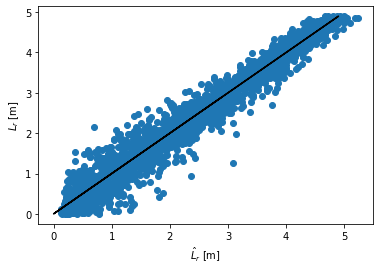

In [33]:
predizioni_pruned = pruned_model.predict(X_test.reshape((X_test.shape[0],20,333,1)))
plt.scatter(predizioni_pruned,Y_test)
plt.xlabel("$\hat{L}_r$ [m]")
plt.ylabel("$L_r$ [m]")
plt.plot(Y_test, Y_test ,'k-')

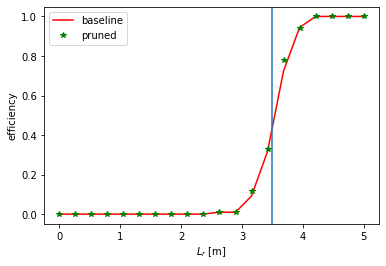

In [34]:
numer_p,_ = np.histogram(Y_test[predizioni_pruned.reshape(2000,)>soglia], bins=20, range=(0.,5.))
denum_p,_= np.histogram(Y_test, bins=20, range=(0.,5.))

eff_p = numer_p/denum_p

_ = plt.plot(lrvalues,eff, 'r-', label='baseline')
_ = plt.plot(lrvalues,eff_p, 'g*', label='pruned')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("$L_r$ [m]")
_ = plt.ylabel("efficiency")
_ = plt.legend()



In [67]:
# check dell'effettiva compressione del modello

# helper function per comprimere i lmodello con gzip e misurare la size del modello compresso

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size of gzipped baseline Keras model in MB: %.2f MB" % (get_gzipped_model_size('float_model_best_10.h5')/ float(2**20)))
print("Size of gzipped pruned Keras model in MB: %.2f MB" % (get_gzipped_model_size('pruned_model.h5')/ float(2**20))) 

Size of gzipped baseline Keras model in MB: 23.86 MB
Size of gzipped pruned Keras model in MB: 5.68 MB


In [35]:
# quantizzazione: usiamo tensorflow quantizer per quantizzare il modello a 8 bit

import tensorflow_model_optimization as tfmot

# sfruttiamo il modulo tfmot.quantization di tensorflow model optimization

# nel quantizzare i modelli (pesi e funzione di attivazione) è importante utilizzare la tecnica del quantization aware training 
# riaddestrando (anche solo per poche epoche) il modello quantizzato. La semplice quantizzazione di un modello pre-addestrato (post training quantization) di norma 
# porta ad uno scadimento importante delle prestazioni del modello finale


# quantizziamo il modello pruned usando la quantizzazione di tf a 8 bit: compressione x4, miglioramento latenza CPU in inferenza ~x1.5-4
q_aware_model = tfmot.quantization.keras.quantize_model(pruned_model)

# quantized aware training richiede la ricompilazione del modello (stessi parametri del baseline model)
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
q_aware_model.compile(optimizer=OPTIMIZER,
              loss='mse',
              metrics=['mae'])

q_aware_model.summary()
# anche in questo caso tensorflow implementa un wrapper all'interno del modello che aiuta nelle operazioni di trainign del modello 
# quantizzato

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 333, 1)]      0         
                                                                 
 quantize_layer_2 (QuantizeL  (None, 20, 333, 1)       3         
 ayer)                                                           
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 20, 333, 64)      771       
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 20, 333, 64)      37059     
 pperV2)                                                         
                                                                 
 quant_conv2d_2 (QuantizeWra  (None, 20, 333, 64)      36929     
 pperV2)                                                     

In [36]:
# trainign schedules
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'q_best.h5',
        monitor='val_mae',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

In [38]:
# let's start to test with fine tuning for 1 epoch
history = q_aware_model.fit(X_train, Y_train, epochs=5, validation_split=0.2, verbose=1, callbacks=[model_checkpoint])

Epoch 1/5
200/200 [==============================] - 14s 62ms/step - loss: 0.1865 - mae: 0.3381 - val_loss: 0.1273 - val_mae: 0.2707
Epoch 2/5
200/200 [==============================] - 12s 59ms/step - loss: 0.1268 - mae: 0.2823 - val_loss: 0.1278 - val_mae: 0.2666
Epoch 3/5
200/200 [==============================] - 12s 58ms/step - loss: 0.1051 - mae: 0.2558 - val_loss: 0.1324 - val_mae: 0.2922
Epoch 4/5
200/200 [==============================] - 12s 62ms/step - loss: 0.0918 - mae: 0.2400 - val_loss: 0.1093 - val_mae: 0.2466
Epoch 5/5
200/200 [==============================] - 13s 64ms/step - loss: 0.0799 - mae: 0.2231 - val_loss: 0.1123 - val_mae: 0.2644


In [39]:
q_aware_model.load_weights('q_best.h5')
q_aware_model.save('q_aware_model.h5')

In [40]:
# Prestazioni dei modelli: baseline, pruned e pruned+quantized

print('Baseline model:')
basescore = baseline_model.evaluate(X_test, Y_test, verbose=2)
print()
print('Pruned model:')
score_p = pruned_model.evaluate(X_test, Y_test, verbose=2)
print()
print('Pruned+Quantized model:')
score_q = q_aware_model.evaluate(X_test, Y_test, verbose=2)

Baseline model:
63/63 - 1s - loss: 0.1028 - mae: 0.2407 - 841ms/epoch - 13ms/step

Pruned model:
63/63 - 1s - loss: 0.1028 - mae: 0.2407 - 812ms/epoch - 13ms/step

Pruned+Quantized model:
63/63 - 1s - loss: 0.1060 - mae: 0.2446 - 1s/epoch - 19ms/step


63/63 [==============================] - 1s 15ms/step


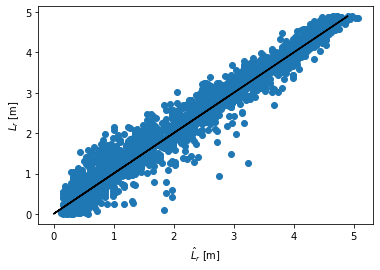

In [41]:
predizioni_q = q_aware_model.predict(X_test.reshape((X_test.shape[0],20,333,1)))
plt.scatter(predizioni_q,Y_test)
plt.xlabel("$\hat{L}_r$ [m]")
plt.ylabel("$L_r$ [m]")
plt.plot(Y_test, Y_test ,'k-')

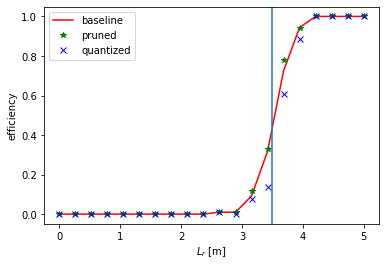

In [42]:
numer_q,_ = np.histogram(Y_test[predizioni_q.reshape(2000,)>soglia], bins=20, range=(0.,5.))
denum_q,_ = np.histogram(Y_test, bins=20, range=(0.,5.))

eff_q = numer_q/denum_q

_ = plt.plot(lrvalues,eff, 'r-', label='baseline')
_ = plt.plot(lrvalues,eff_p, 'g*', label='pruned')
_ = plt.plot(lrvalues,eff_q, 'bx', label='quantized')
_ = plt.axvline(x=soglia)
_ = plt.xlabel("$L_r$ [m]")
_ = plt.ylabel("efficiency")
_ = plt.legend()


In [69]:
print("Size of gzipped pruned+quantized Keras model in MB: %.2f MB" % (get_gzipped_model_size('q_aware_model_10.h5')/ float(2**20))) 

Size of gzipped pruned+quantized Keras model in MB: 12.53 MB


In [45]:
# Conversione dei modelli in TFlite in modo da eliminare il wrapper e verificare che effettivamente il modello 
# risulta correttamente compresso 

# pruned + compressed model
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# baseline model
baseline_model = keras.models.load_model('float_model.h5')
float_converter = tf.lite.TFLiteConverter.from_keras_model(baseline_model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Pruned model in Mb:", os.path.getsize(pruned_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Float model in Mb: 10.959980010986328
Pruned model in Mb: 10.959980010986328
Quantized model in Mb: 2.7733154296875
